In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv(r"social_media_engagement1.csv")

In [3]:
df.head(10)

,post_id,platform,post_type,post_time,likes,comments,shares,post_day,sentiment_score
0,1,Facebook,image,8/17/2023 14:45,2121,474,628,Thursday,positive
1,2,Facebook,carousel,5/14/2023 0:45,3660,432,694,Sunday,neutral
2,3,Instagram,poll,2/21/2023 16:15,4955,408,688,Tuesday,negative
3,4,Twitter,image,11/16/2023 0:45,1183,90,187,Thursday,negative
4,5,Twitter,video,5/23/2023 0:30,3499,247,286,Tuesday,positive
5,6,Instagram,carousel,5/5/2023 20:00,256,186,211,Friday,neutral
6,7,Instagram,image,2/26/2023 11:45,1982,30,906,Sunday,positive
7,8,Instagram,text,10/28/2023 19:30,1274,45,216,Saturday,neutral
8,9,Facebook,video,5/2/2023 6:15,317,249,221,Tuesday,neutral
9,10,Twitter,carousel,5/11/2023 11:00,1878,225,438,Thursday,neutral


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   post_id          100 non-null    int64 
 1   platform         100 non-null    object
 2   post_type        100 non-null    object
 3   post_time        100 non-null    object
 4   likes            100 non-null    int64 
 5   comments         100 non-null    int64 
 6   shares           100 non-null    int64 
 7   post_day         100 non-null    object
 8   sentiment_score  100 non-null    object
dtypes: int64(4), object(5)
memory usage: 7.2+ KB


In [5]:
df.isnull().sum()

post_id            0
platform           0
post_type          0
post_time          0
likes              0
comments           0
shares             0
post_day           0
sentiment_score    0
dtype: int64

In [6]:
df['post_time'] = pd.to_datetime(df['post_time'])

In [7]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'midnight'

# Create new column
df['time_category'] = df['post_time'].dt.hour.apply(time_of_day)

In [8]:
df.head()

,post_id,platform,post_type,post_time,likes,comments,shares,post_day,sentiment_score,time_category
0,1,Facebook,image,2023-08-17 14:45:00,2121,474,628,Thursday,positive,afternoon
1,2,Facebook,carousel,2023-05-14 00:45:00,3660,432,694,Sunday,neutral,midnight
2,3,Instagram,poll,2023-02-21 16:15:00,4955,408,688,Tuesday,negative,afternoon
3,4,Twitter,image,2023-11-16 00:45:00,1183,90,187,Thursday,negative,midnight
4,5,Twitter,video,2023-05-23 00:30:00,3499,247,286,Tuesday,positive,midnight


In [9]:
df.dtypes

post_id                     int64
platform                   object
post_type                  object
post_time          datetime64[ns]
likes                       int64
comments                    int64
shares                      int64
post_day                   object
sentiment_score            object
time_category              object
dtype: object

In [10]:
df_clean = df.drop(columns=['post_id','post_time'])

In [11]:
df_clean.dtypes

platform           object
post_type          object
likes               int64
comments            int64
shares              int64
post_day           object
sentiment_score    object
time_category      object
dtype: object

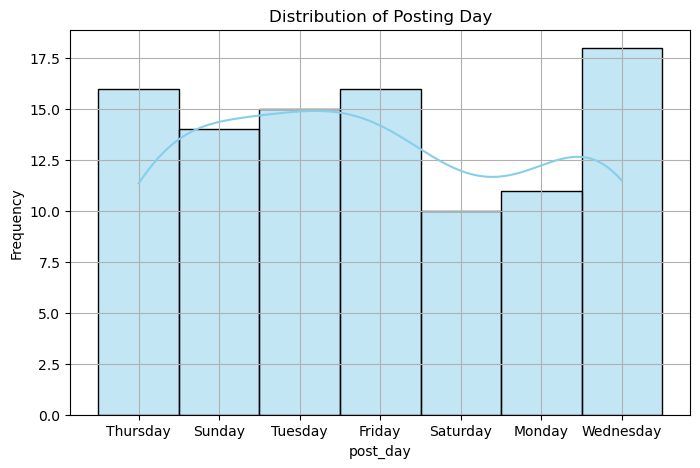

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df['post_day'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Posting Day')
plt.xlabel('post_day')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

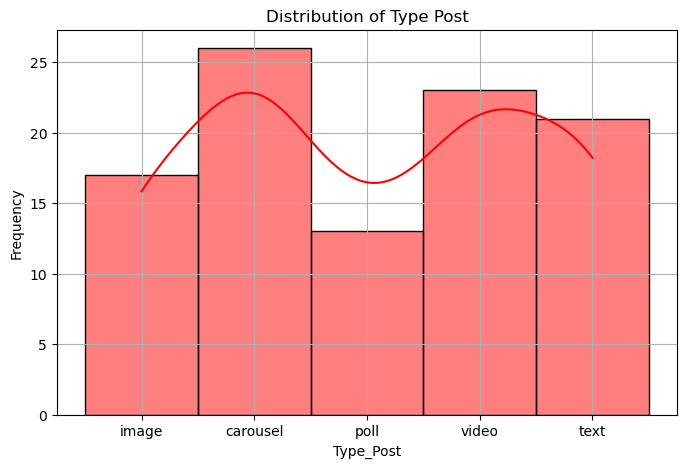

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(df['post_type'], bins=30, kde=True, color='red')
plt.title('Distribution of Type Post')
plt.xlabel('Type_Post')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

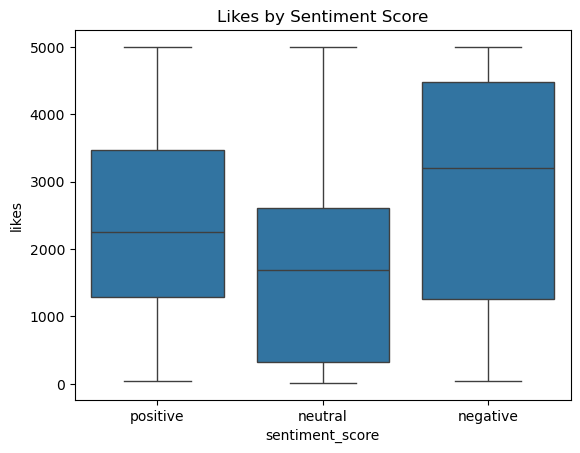

In [14]:
sns.boxplot(x='sentiment_score', y='likes', data=df)
plt.title('Likes by Sentiment Score')
plt.show()

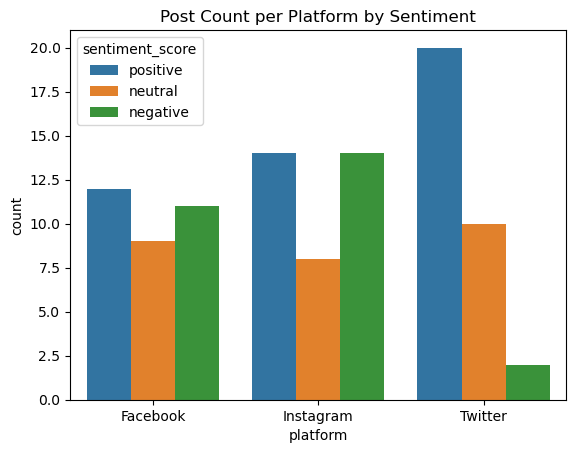

In [15]:
sns.countplot(x='platform', hue='sentiment_score', data=df)
plt.title('Post Count per Platform by Sentiment')
plt.show()

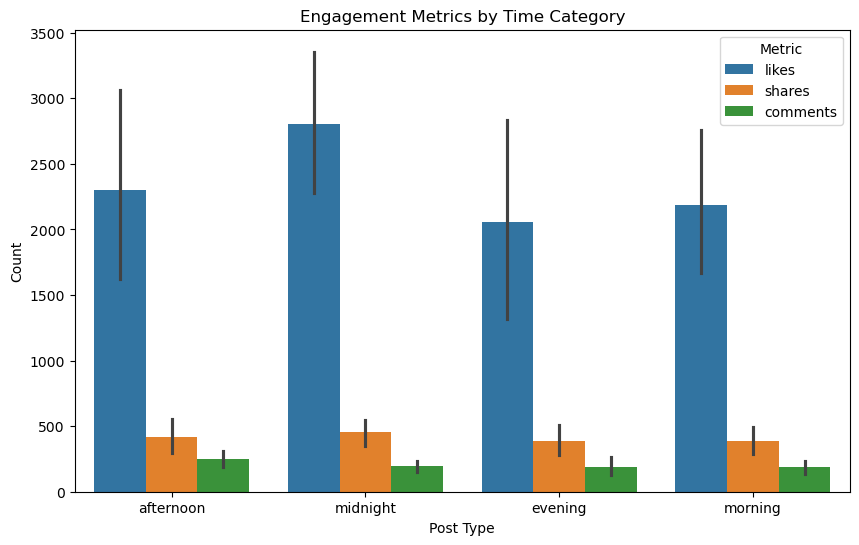

In [16]:
df_melted = df.melt(id_vars='time_category', value_vars=['likes', 'shares', 'comments'],
                    var_name='Metric', value_name='Count')

# Create grouped barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='time_category', y='Count', hue='Metric')
plt.title('Engagement Metrics by Time Category')
plt.ylabel('Count')
plt.xlabel('Post Type')
plt.legend(title='Metric')
plt.show()

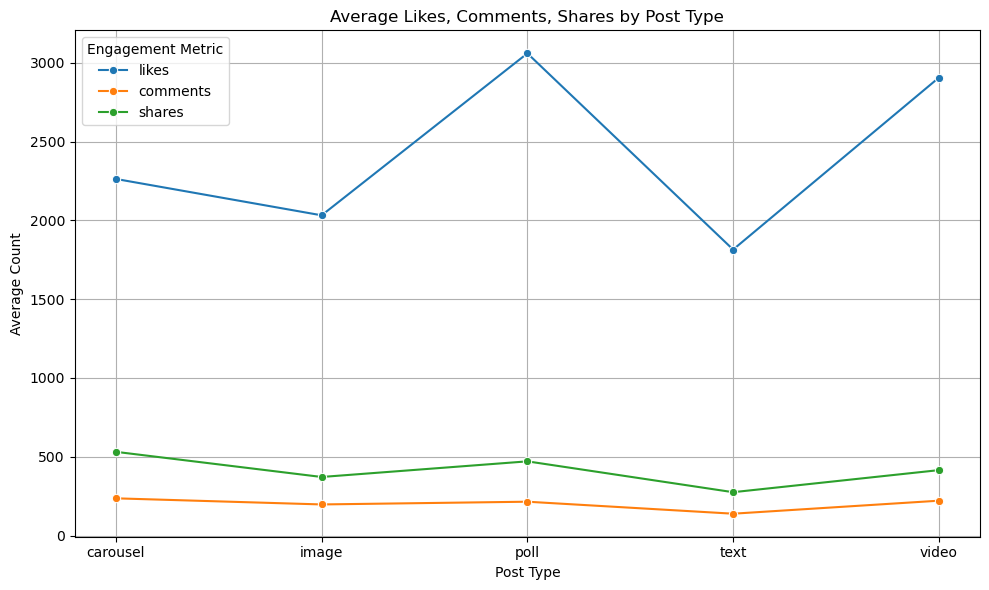

In [17]:
avg_engagement = df.groupby('post_type')[['likes', 'comments', 'shares']].mean().reset_index()

# Step 2: Melt the data to long format for seaborn
df_melted = avg_engagement.melt(id_vars='post_type', 
                                value_vars=['likes', 'comments', 'shares'], 
                                var_name='Metric', 
                                value_name='Average Count')

# Step 3: Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='post_type', y='Average Count', hue='Metric', marker='o')

plt.title('Average Likes, Comments, Shares by Post Type')
plt.xlabel('Post Type')
plt.ylabel('Average Count')
plt.grid(True)
plt.legend(title='Engagement Metric')
plt.tight_layout()
plt.show()

In [18]:
# Step 1: Create total engagement column
df_clean['engagement_total'] = df_clean['likes'] + df_clean['comments'] + df_clean['shares']

# Step 2: Create binary target (1 = high engagement, 0 = low)
threshold = df_clean['engagement_total'].median()
df_clean['high_engagement'] = (df_clean['engagement_total'] >= threshold).astype(int)


In [19]:
df_model = df_clean.drop(columns=['likes', 'comments', 'shares', 'engagement_total'])


In [20]:
df_encoded = pd.get_dummies(df_model, drop_first=True)


In [21]:
df_encoded = pd.get_dummies(df_model, drop_first=True)


In [22]:
df_encoded.dtypes

high_engagement             int32
platform_Instagram           bool
platform_Twitter             bool
post_type_image              bool
post_type_poll               bool
post_type_text               bool
post_type_video              bool
post_day_Monday              bool
post_day_Saturday            bool
post_day_Sunday              bool
post_day_Thursday            bool
post_day_Tuesday             bool
post_day_Wednesday           bool
sentiment_score_neutral      bool
sentiment_score_positive     bool
time_category_evening        bool
time_category_midnight       bool
time_category_morning        bool
dtype: object

In [23]:
X = df_encoded.drop('high_engagement', axis=1)
y = df_encoded['high_engagement']


In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(rf, X, y, cv=5)
print("CV Scores:", scores)
print("Mean Accuracy:", scores.mean())

CV Scores: [0.8  0.7  0.55 0.65 0.55]
Mean Accuracy: 0.65


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y) 

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
from sklearn.metrics import accuracy_score

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

Test Accuracy: 0.75


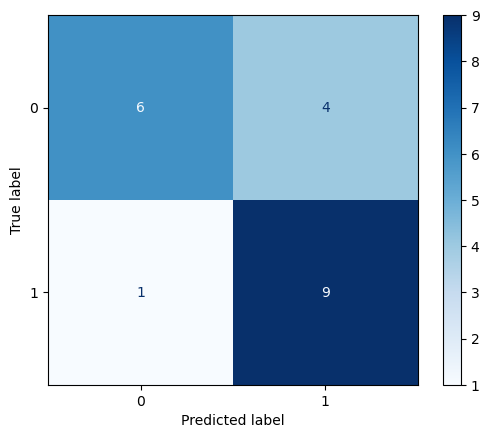

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')

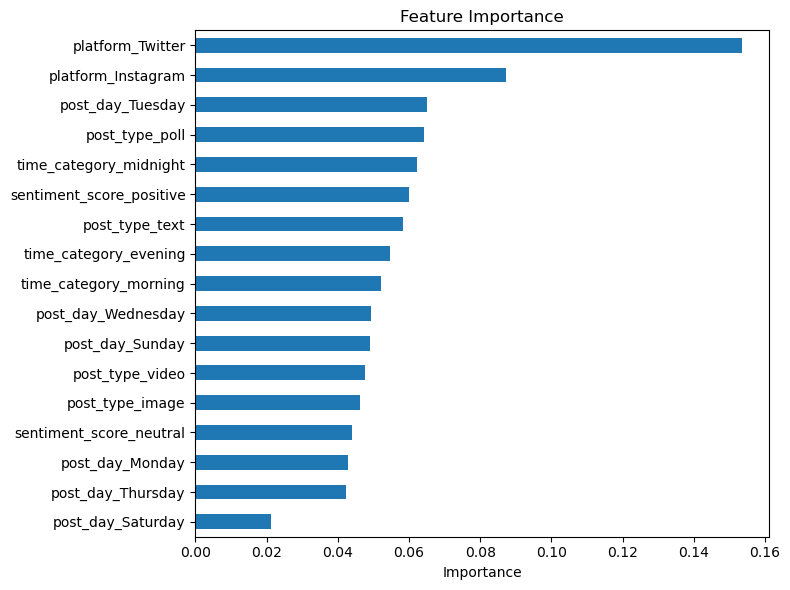

In [29]:
importances = rf.feature_importances_
pd.Series(importances, index=X.columns).sort_values().plot.barh(figsize=(8, 6), title="Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [30]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", acc_lr)

Logistic Regression Accuracy: 0.75


In [31]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", acc_xgb)


XGBoost Accuracy: 0.75


In [32]:
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)


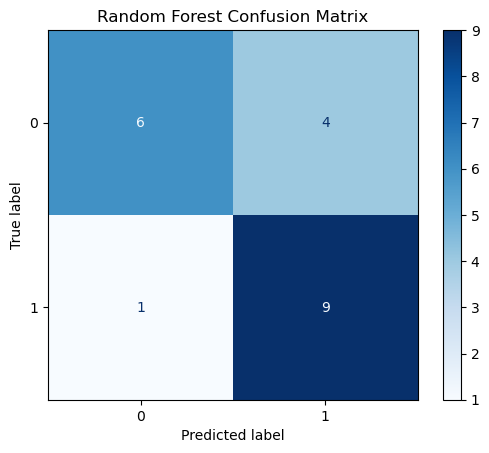

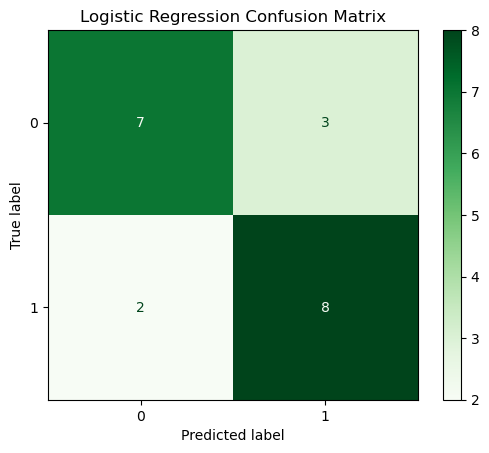

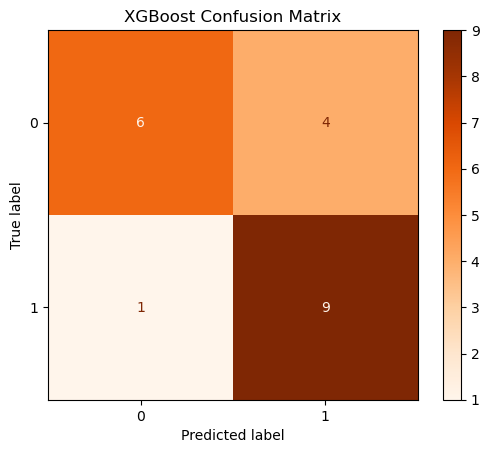

In [33]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

# Logistic Regression
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# XGBoost
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.show()

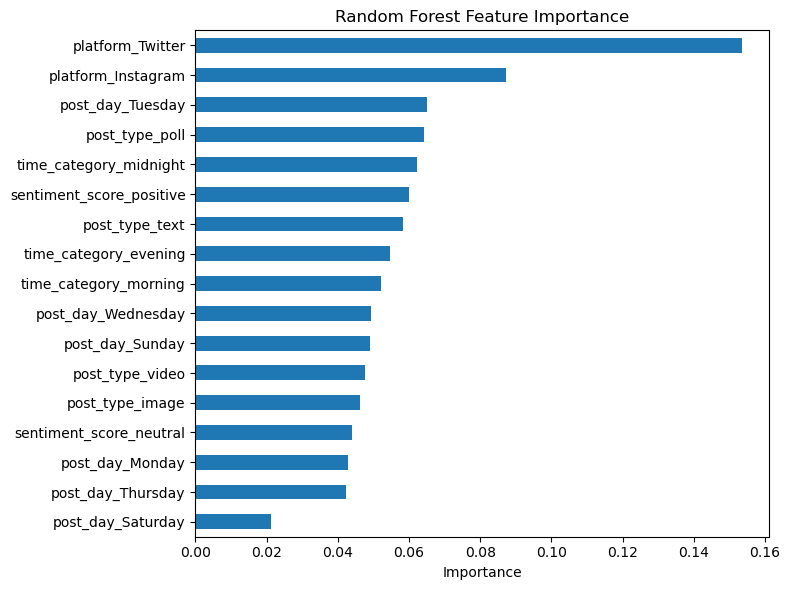

In [34]:
rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
rf_importance.sort_values().plot.barh(figsize=(8, 6), title="Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

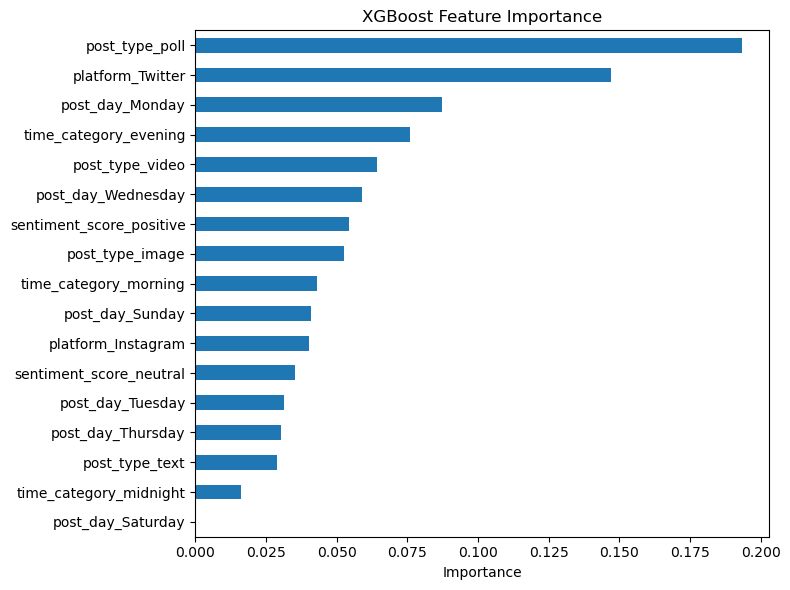

In [35]:
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns)
xgb_importance.sort_values().plot.barh(figsize=(8, 6), title="XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [36]:
svc = SVC(kernel='rbf', probability=True, random_state=42)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

acc_svc = accuracy_score(y_test, y_pred_svc)
print("🔵 SVM Accuracy:", acc_svc)

🔵 SVM Accuracy: 0.75


In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Re-split the scaled data
from sklearn.model_selection import train_test_split

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_s, y_train_s)
y_pred_knn = knn.predict(X_test_s)
acc_knn = accuracy_score(y_test_s, y_pred_knn)
print("🔵 KNN Accuracy:", acc_knn)


🔵 KNN Accuracy: 0.4


In [39]:
nb = GaussianNB()
nb.fit(X_train_s, y_train_s)
y_pred_nb = nb.predict(X_test_s)
acc_nb = accuracy_score(y_test_s, y_pred_nb)
print("🟠 Naive Bayes Accuracy:", acc_nb)

🟠 Naive Bayes Accuracy: 0.7


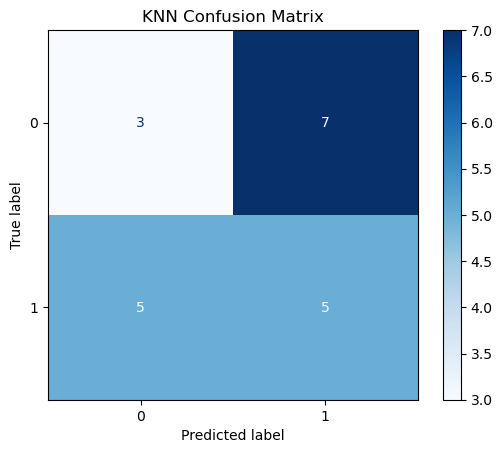

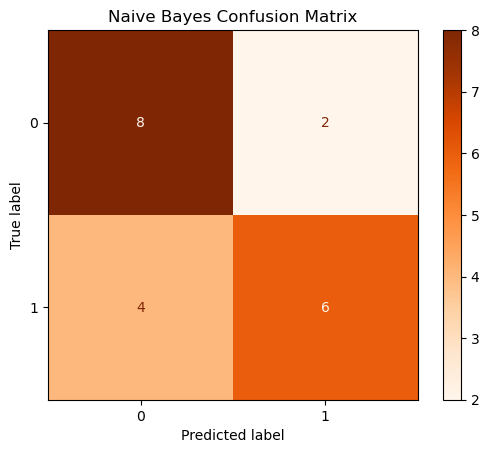

In [40]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_s, y_test_s, cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()

# Naive Bayes
ConfusionMatrixDisplay.from_estimator(nb, X_test_s, y_test_s, cmap='Oranges')
plt.title("Naive Bayes Confusion Matrix")
plt.show()

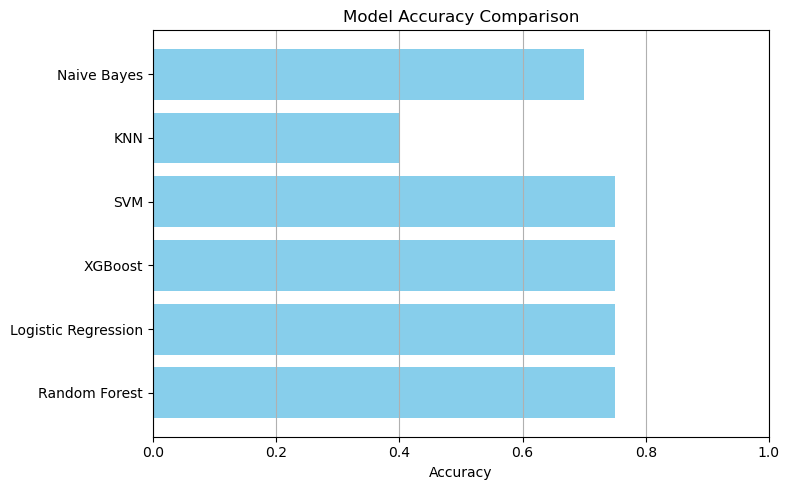

In [41]:
model_names = ["Random Forest", "Logistic Regression", "XGBoost", "SVM", "KNN", "Naive Bayes"]
accuracies = [acc, acc_lr, acc_xgb, acc_svc, acc_knn, acc_nb]

plt.figure(figsize=(8, 5))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [90]:
import joblib

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(rf, 'model_rf.pkl')
joblib.dump(lr, 'model_lr.pkl')
joblib.dump(xgb, 'model_xgb.pkl')
joblib.dump(svc, 'model_svc.pkl')



['model_svc.pkl']